<a href="https://colab.research.google.com/github/JoSungHun/Deeplearning/blob/master/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Neural Style Transfer

* Due date: **2019/06/10 00:00** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment

* Prepare style reference image and target image


In [0]:
from keras.preprocessing.image import img_to_array

# This is the url to the image you want to transform.
target_image_url = 'https://drive.google.com/uc?id=1aKi9N6eKoAxL6up1fvKh9dlVbu6e_55B'
# This is the url to the style image.
style_reference_image_url = 'https://drive.google.com/uc?id=1q56lpC-BmhWYPowS4Gok-hu0dT-Z2U7M'

Using TensorFlow backend.


* The functions for data preprocessing are given as follows.

In [0]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras.applications import resnet50

img_width, img_height = 514, 700

def load_image(image_url, img_width, img_height):
  response = requests.get(image_url, stream=True)
  img = Image.open(BytesIO(response.content))
  img = img.resize((img_width, img_height))
  
  return img_to_array(img)

def preprocess_image(img):
  img = np.expand_dims(img, axis=0)
  img = resnet50.preprocess_input(img)
  return img

def deprocess_image(x):
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68
  x = x[:,:,::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

* Show your style reference image and target image (5pts)

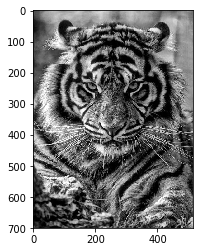

In [0]:
# show style reference image
import matplotlib.pyplot as plt
style_reference_image = load_image(style_reference_image_url, img_width, img_height).astype('uint8')
plt.imshow(style_reference_image)

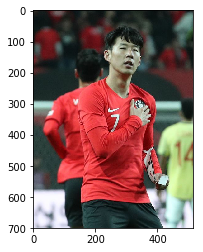

In [0]:
# show target image
target_image = load_image(target_image_url, img_width, img_height).astype('uint8')
plt.imshow(target_image)

* Describe resnet50 architecture in Keras (20pts)
  * Refer to https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
  * **Question** How many convolutional layers in this architecture?
  * **Question** What is the difference between `identity_block` and `conv_block`? Why do we need this difference?
  

* Build input tensor and load ResNet50 pretrained on imagenet (10pts)

In [0]:
from keras import backend as K
K.set_learning_phase(0)

# write code below
target_image = preprocess_image(load_image(target_image_url,img_width,img_height))
target_image = K.constant(target_image)

style_reference_image = preprocess_image(load_image(style_reference_image_url,img_width,img_height))
style_reference_image = K.constant(style_reference_image)

combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = resnet50.ResNet50(input_tensor=input_tensor,
                       weights='imagenet',
                       include_top=False)
print('Model loaded.')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Model loaded.


* The loss functions are given as follows.

In [0]:
def content_loss(base, combination):
  return K.mean(K.square(combination - base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.mean(K.square(S - C))

def total_variation_loss(x):
  a = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
  b = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  return K.mean(K.pow(a + b, 1.25))

* Define the total loss (20pts)
  * Use **the last activations** to compute the content loss.
  * Use **the inputs of each `conv_block`** to compute the style loss.

In [0]:
# write code below
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'res5b_branch2a'
style_layers = ['res2a_branch2a',
                'res3a_branch2a',
                'res4a_branch2a',
                'res5a_branch2a']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

* Special class for computing loss and gradients is given as follows.

In [0]:
# setting up the gradient-descent process

# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()

* Write a code to do iterative updates. (10pts)
  * Refer to the course material.

In [0]:
# write code below
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(load_image(target_image_url,img_width,img_height))
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                   fprime=evaluator.grads, maxfun=20)
  print('Current loss value:', min_val)
  # Save current generated image
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  plt.imsave(fname, img)
  end_time = time.time()
  print('Image saved as', fname)
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 25251990.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 14s
Start of iteration 1
Current loss value: 6533566.5
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 7s
Start of iteration 2
Current loss value: 2776560.8
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 7s
Start of iteration 3
Current loss value: 1542649.8
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 8s
Start of iteration 4
Current loss value: 1006256.44
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 725619.75
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 554552.9
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 8s
Start of iteration 7
Current loss value: 453017.47
Im

* Show all images: target, style reference, and generated images. (5pts)

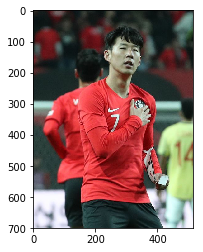

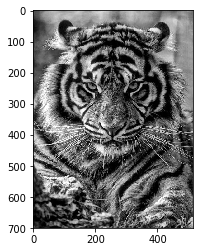

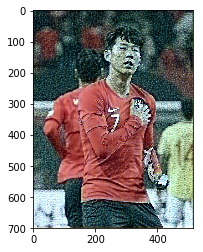

In [0]:
# write code below
import matplotlib.pyplot as plt

# show target image
target_image = load_image(target_image_url,img_width,img_height).astype('uint8')
plt.imshow(target_image)
plt.figure()

# show style reference image
style_reference_image = load_image(style_reference_image_url,img_width,img_height).astype('uint8')
plt.imshow(style_reference_image)
plt.figure()

# show generated image
plt.imshow(img)

* Suppose that you want to transfer style components as little as possible. Write a code for doing this, and show the results.

In [0]:
# write code below
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'res5b_branch2a'
style_layers = ['res5a_branch2a']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)


grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()

# write code below
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(load_image(target_image_url,img_width,img_height))
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                   fprime=evaluator.grads, maxfun=20)
  print('Current loss value:', min_val)
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  plt.imsave(fname, img)
  end_time = time.time()
  print('Image saved as', fname)
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1470.6528
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 9s
Start of iteration 1
Current loss value: 621.85956
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 376.32175
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 7s
Start of iteration 3
Current loss value: 273.13324
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 8s
Start of iteration 4
Current loss value: 219.7422
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 186.88419
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 165.88599
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 150.27618
Image

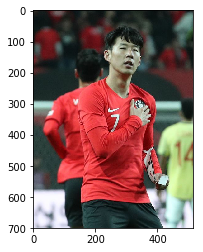

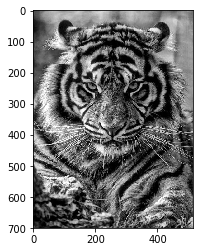

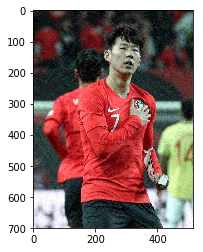

In [0]:
  # write code below
import matplotlib.pyplot as plt

# show target image
target_image = load_image(target_image_url,img_width,img_height).astype('uint8')
plt.imshow(target_image)
plt.figure()

# show style reference image
style_reference_image = load_image(style_reference_image_url,img_width,img_height).astype('uint8')
plt.imshow(style_reference_image)
plt.figure()

# show generated image
plt.imshow(img)